In [1]:
!uv pip install numba==0.56.4  matplotlib==3.8.0 networkx==3.1 numpy==1.23.5 pandas==2.1.4 scikit-learn==1.3.0 scipy==1.11.4 seaborn==0.12.2 ortools==9.8.3296 gdown tigramite

Audited 11 packages in 21ms


In [2]:
# imports
import copy

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from datetime import datetime, timedelta

# Metrics and Evaluation
from sklearn.metrics import confusion_matrix

In [3]:
# Data preprocessing and graph visualization
from tigramite import data_processing as pp
from tigramite import plotting as tp
# Causal discovery
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.pcmci import PCMCI
from tigramite.models import Models
# from rpcmci import RPCMCI
import networkx as nx
# Linear model
from sklearn.linear_model import LinearRegression

In [4]:
def reshape_and_resample_df(filename, val_type='seasonal_dtr_val_std', sample_freq='3D', sampling_type='mean',
                            fill_missing=False, fill_missing_value=999., use_evap=False):
    # Load DataFrame
    df = pd.read_csv(filename)
    freq = int(sample_freq[0])

    # Convert 'VAC' values
    vac_conversion = {'a': 1, 'b': 2, 'c': 3, 'd': 4, '0': 0}
    df['VAC'] = df['VAC'].replace(vac_conversion).astype(float)

    # Pivot the DataFrame
    pivoted_df = df.pivot(index='date', columns='var', values=val_type)
    pivoted_df.index = pd.to_datetime(pivoted_df.index)

    # only keep years starting from 1990
    # all_days_to_keep = np.arange(datetime(1993, 3, 1), datetime(2022, 9, 30),
    #                              timedelta(days=1)).astype(datetime)
    all_days_to_keep = np.arange(datetime(1950, 3, 1), datetime(2022, 9, 30),
                                 timedelta(days=1)).astype(datetime)
    dates_to_keep = [i for i in all_days_to_keep if i in pivoted_df.index]
    pivoted_df = pivoted_df.loc[dates_to_keep]

    if use_evap:
        pivoted_df['evap'] = pivoted_df['slhf'] / pivoted_df['slhf'] + \
        pivoted_df['sshf']

    # Extract and prepare 'VAC' column
    date_to_vac = df.drop_duplicates(subset='date').set_index('date')['VAC']
    date_to_vac.index = pd.to_datetime(date_to_vac.index)
    date_to_vac = date_to_vac.loc[dates_to_keep]

    if fill_missing:
        date_array = pivoted_df.index

        # fill in missing days with 999.
        filled_df = pd.DataFrame(fill_missing_value, index=all_days_to_keep,
                                 columns=pivoted_df.columns)
        filled_df.index = pd.to_datetime(filled_df.index).strftime('%Y-%m-%d')

        filled_vac_df = pd.Series(fill_missing_value, index=all_days_to_keep)
        filled_vac_df.index = pd.to_datetime(
            filled_vac_df.index).strftime('%Y-%m-%d')

        for day in filled_df.index:
            if day in date_array:
                filled_df.loc[day] = pivoted_df.loc[day]
                filled_vac_df.loc[day] = date_to_vac.loc[day]

        pivoted_df = filled_df
        date_to_vac = filled_vac_df

    # Resample data
    if sampling_type == 'mean':
        resampled = pivoted_df.copy().resample(sample_freq).mean().dropna()
        resampled_vac = np.round(
            date_to_vac.resample(sample_freq).median().dropna())
    elif sampling_type == 'subsample':
        # Assuming 'sample_freq' contains a valid integer for frequency
        resampled = pivoted_df.copy().iloc[::freq]
        resampled_vac = date_to_vac.iloc[::freq]
    else:
        raise ValueError('This type of sampling is not supported!')

    # Assign 'VAC' values to the resampled DataFrame
    resampled['VAC'] = resampled_vac

    return resampled

In [5]:
def get_pandas_and_tigramite_dfs(filename, val_type='seasonal_dtr_val_std', sample_freq='1D', sampling_type='mean',
                                 vals_to_drop=None, fill_missing=False, fill_missing_value=999., use_evap=False):
    # Reshape and resample DataFrame
    pd_df = reshape_and_resample_df(filename, val_type=val_type,
                                    sample_freq=sample_freq,
                                    sampling_type=sampling_type,
                                    fill_missing=fill_missing,
                                    fill_missing_value=fill_missing_value,
                                    use_evap=use_evap)

    vac_values = pd_df['VAC'].copy().to_numpy()

    # rename columns
    pd_df = pd_df.rename(columns={'slhf': 'LH',
                                  'sshf': 'SH',
                                  'swvl123': 'SM',
                                  't2m': 'T2m',
                                  'tp': 'TP',
                                  'stream': 'Stream',
                                  'ssrd': 'SW'})

    # Drop specified columns if provided
    if vals_to_drop is not None:
        pd_df.drop(vals_to_drop, axis=1, inplace=True)
    
    # Sort the DataFrame by index
    pd_df.sort_index(inplace=True)

    # Convert to new DataFrame with appropriate column names
    tig_df = pp.DataFrame(pd_df.to_numpy(), var_names=pd_df.columns, missing_flag=999.)

    return pd_df, tig_df, vac_values

- Mean air temperature 2m above the ground (T2m),
- Root-zone (1m) soil moisture (SM),
- Surface sensible heat flux (SH), sign swapped to obtain positive upward fluxes,
- Surface latent heat flux (LH), sign swapped as for SH,
- Stream function at 250 hPa (Stream), describing atmospheric circulation patterns,
- Shortwave downward radiation (SW),
- Precipitation (TP),
- An expert guided regime classification index, i.e. the vegetation-atmosphere coupling (VAC) index (https://doi.org/10.1002/2015GL066563) based on the co-occcurence of soil moisture and temperature anomalies using thresholding (See Figure below, left panel a).

In [6]:
filled_pd_df, filled_tigramite_df, filled_vac_values = get_pandas_and_tigramite_dfs(
    './LAF_WWCE_SM_VAC_dtr_std_MAMJJAS.csv',
    sampling_type='subsample',
    sample_freq='1D',
    vals_to_drop=['swvl2', 'swvl3', 'swvl1', 'VAC'],
    fill_missing=True, fill_missing_value=999., use_evap=False)

filled_pd_df

var,LH,SH,SW,Stream,SM,T2m,TP
1950-03-01,-2.154144,-0.125094,-1.410969,-1.501948,1.432580,-2.886783,-0.766967
1950-03-02,-2.160544,-0.208967,-1.129304,-0.910112,1.389200,-2.790230,-0.918155
1950-03-03,-2.111713,-0.631610,-1.046753,-0.414591,1.349157,-2.440718,-0.943481
1950-03-04,-2.374583,-1.691506,-1.905727,-0.138127,1.324861,-1.912801,-0.763066
1950-03-05,-2.263274,-1.272122,-1.444837,0.427211,1.315524,-1.638096,-0.933555
...,...,...,...,...,...,...,...
2022-09-25,-1.214774,-1.058357,-1.717759,0.064268,-0.898910,-0.458938,0.744294
2022-09-26,-0.845842,-1.899847,-1.889848,0.142732,-0.828307,-0.601944,1.147305
2022-09-27,-0.558362,-2.052421,-1.912754,0.041978,-0.701472,-0.763503,2.186342
2022-09-28,-1.189397,-2.025593,-2.225434,-0.266826,-0.527653,-0.845023,2.473897


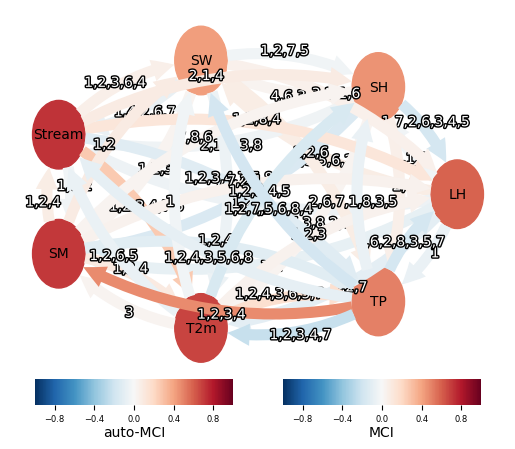

In [7]:
# Set hyperparameters
tau_min = 1
tau_max = 8
# pc_alpha = None
# alpha_level = 0.01

pcmci = PCMCI(dataframe=filled_tigramite_df,
              cond_ind_test=RobustParCorr())

pcmci_results = pcmci.run_pcmci(tau_min=tau_min, tau_max=tau_max)#, pc_alpha=pc_alpha, alpha_level=alpha_level)

tp.plot_graph(val_matrix=pcmci_results['val_matrix'],
              graph=pcmci_results['graph'], var_names=filled_tigramite_df.var_names,
              node_aspect=0.5, node_size=0.5
              )
plt.show()

In [8]:
model = Models(
    dataframe=filled_tigramite_df,
    model=LinearRegression(),
)
all_parents = pcmci.return_parents_dict(pcmci_results["graph"], pcmci_results["val_matrix"])
model.fit_full_model(all_parents)

{0: {'data_transform': None, 'model': LinearRegression()},
 1: {'data_transform': None, 'model': LinearRegression()},
 2: {'data_transform': None, 'model': LinearRegression()},
 3: {'data_transform': None, 'model': LinearRegression()},
 4: {'data_transform': None, 'model': LinearRegression()},
 5: {'data_transform': None, 'model': LinearRegression()},
 6: {'data_transform': None, 'model': LinearRegression()}}

In [9]:
y_trues = []
for i in range(len(all_parents)):
    Y = [(i, 0)]
    X = []
    Z = all_parents[i] # ensure the resulting y_true matches the length of the predicted values
    arr = filled_tigramite_df.construct_array(X, Y, Z,
                                    tau_max=tau_max,
                                    mask_type=None,
                                    cut_off="2xtau_max",
                                    remove_overlaps=True,
                                    verbosity=False)
    y_true = arr[0][0, :]
    y_trues.append(y_true)

In [10]:
predictions = model.predict_full_model(cut_off="2xtau_max",)

In [11]:
# compute RMSE for each variable
for i in range(len(predictions)):
    print(f"RMSE for variable {filled_pd_df.columns[i]}: {np.sqrt(np.mean((predictions[i] - y_trues[i]) ** 2))}")

RMSE for variable LH: 0.32557686081668086
RMSE for variable SH: 0.5719274669490494
RMSE for variable SW: 0.5045686904965971
RMSE for variable Stream: 0.2207405388023029
RMSE for variable SM: 0.030213213753364755
RMSE for variable T2m: 0.18967788464360932
RMSE for variable TP: 0.8038609701128868
